[Reference](https://github.com/j-sadowski/FromRtoPython/blob/master/StratifiedRandomSampling.ipynb)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def assign_treatments(df, experiment_size, seed  = 42, level = 0):
    """
    1. Given a dataframe, add a column for treatment
    2. Randomly assign half of those rows to the 'B' treatment
    3. Get the dummy variables for the treatment column
    4. Get the dummy variables for the city column 
    5. Return a modified dataframe
    """
    workdf = df.copy()
    workdf['treatment'] = 'A'
    if level == 0:
        experiment_idx = workdf.sample(int(experiment_size/2),random_state = seed).index
    if level == 1:
        experiment_idx = list(workdf[workdf['town_size']=='town']\
                              .sample(int(experiment_size/4),random_state = seed).index)\
                         + list(workdf[workdf['town_size']=='city']\
                               .sample(int(experiment_size/4),random_state = seed).index)

    workdf.loc[experiment_idx,'treatment'] = 'B'
    dummies = pd.get_dummies(workdf['treatment'])
    citydummies = pd.get_dummies(workdf['town_size'])
    workdf = pd.concat([workdf,dummies,citydummies], axis = 1)
    return(workdf)

def calc_response(df, plist, experiment_size):
    """
    Returns a pandas series of a binomial response
    """
    response = df['city']*df['A']\
                        *np.random.binomial(n = 1, p = plist[0], size = experiment_size)\
                + df['town']*df['A']\
                        *np.random.binomial(n = 1, p = plist[1], size = experiment_size)\
                + df['city']*df['B']\
                        *np.random.binomial(n = 1, p = plist[0] + plist[2],\
                                            size = experiment_size)\
                + df['town']*df['B']\
                        *np.random.binomial(n = 1, p = plist[1] + plist[2],\
                                            size = experiment_size)
    return(response)

def pvalue_print(df, level = 0):
    """
    Get the estimated p value for each group
    Print them out for easy inspection
    """
    if level == 0:
        vec = ['A','B']
        phat_list = []
        psd_list = []
        for val in vec:
            n = len(df['response'][df[val]==1])
            p_hat = np.mean(df['response'][df[val]==1])
            phat_list.append(p_hat)
            print('p_hat' + val,'=',p_hat)
            p_sd = np.sqrt(p_hat*(1-p_hat)/n)
            print('p_hat_sd' + val,'=',p_sd)
            psd_list.append(p_sd)
    if level == 1:
        vec1 = ['A','B']
        vec2 = ['city','town']
        phat_list = []
        psd_list = []
        for i in vec1:
            for j in vec2:
                n = len(df['response'][(df[i]==1) & (df[j]==1)])
                p_hat = np.mean(df['response'][(df[i]==1) & (df[j]==1)])
                print('p_hat' + i + j,'=',p_hat)
                phat_list.append(p_hat)
                p_sd =  np.sqrt(p_hat*(1-p_hat)/n)
                print('p_hat_sd' + i + j,'=',p_sd)
                psd_list.append(p_sd)
    return(phat_list, psd_list)

In [3]:
np.random.seed(42)
population_size = 500000
populationdf = pd.DataFrame(list(range(population_size)))
populationdf.columns = ['id']
#randomly determine whether the individuals are from cities or towns
town_size = ['city']*15 + ['town']
populationdf['town_size'] = np.random.choice(town_size,size = population_size)

In [4]:
populationdf.town_size.value_counts()

city    468520
town     31480
Name: town_size, dtype: int64

In [5]:
experiment_size = int(1000)
completerandom_idx = populationdf.sample(int(experiment_size),random_state = 21).index

completerandom_df = populationdf.loc[completerandom_idx,:]
completerandom_df = assign_treatments(completerandom_df, experiment_size)

In [6]:
completerandom_df.head()

,id,town_size,treatment,A,B,city,town
475807,475807,city,B,0,1,1,0
425191,425191,city,A,1,0,1,0
40378,40378,city,B,0,1,1,0
324437,324437,city,B,0,1,1,0
347750,347750,city,A,1,0,1,0


In [7]:
plist = [0.3,0.1,0.05]

In [8]:
completerandom_df['response'] = 0
completerandom_df['response'] = calc_response(completerandom_df, plist, experiment_size)

In [9]:
phats, psds = pvalue_print(completerandom_df,level = 0)

p_hatA = 0.288
p_hat_sdA = 0.020251222185339826
p_hatB = 0.314
p_hat_sdB = 0.020755914819636352


In [10]:
stats.ttest_ind(completerandom_df['response'][completerandom_df['A']==1], \
                completerandom_df['response'][completerandom_df['B']==1])

Ttest_indResult(statistic=-0.8956973262397737, pvalue=0.37063042188578654)

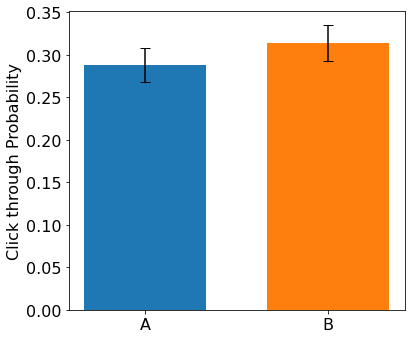

In [11]:
plt.rcParams.update({'font.size': 16})
plt.rcParams["figure.figsize"] = (6,5)
fig, ax = plt.subplots()
ncats = np.arange(1)
width = 0.35
rects1 = ax.bar(0, height = phats[0], width = width, yerr = psds[0],\
                align='center', ecolor='black', capsize=5, label = 'A')
rects2 = ax.bar(width*1.5, height = phats[1],width = width, yerr = psds[1],\
                align='center', ecolor='black', capsize=5, label = 'B')
ax.set_ylabel('Click through Probability')
ax.set_xticks([0,width*1.5])
ax.set_xticklabels(['A','B'])

# Save the figure and show
plt.tight_layout()

In [12]:
#Number of town users in dataset
print(completerandom_df.town_size.value_counts())

#NUmber of tonw users in each treatment
print(completerandom_df[completerandom_df['A']==1].town_size.value_counts())
print(completerandom_df[completerandom_df['B']==1].town_size.value_counts())

city    929
town     71
Name: town_size, dtype: int64
city    476
town     24
Name: town_size, dtype: int64
city    453
town     47
Name: town_size, dtype: int64


In [13]:
townid = populationdf['id'][populationdf['town_size']=='town']
bigcityid = populationdf['id'][populationdf['town_size']=='city']

stratified_idx = list(townid.sample(int(experiment_size/2),random_state = 42).index) \
                 + list(bigcityid.sample(int(experiment_size/2),random_state = 42).index)
stratified_df = populationdf.loc[stratified_idx,:]

In [14]:
stratified_df = assign_treatments(stratified_df, experiment_size, level = 1)

In [15]:
print(stratified_df.town_size.value_counts())
print(stratified_df[stratified_df['A']==1].town_size.value_counts())
print(stratified_df[stratified_df['B']==1].town_size.value_counts())

town    500
city    500
Name: town_size, dtype: int64
town    250
city    250
Name: town_size, dtype: int64
town    250
city    250
Name: town_size, dtype: int64


In [16]:
stratified_df['response'] = 0
stratified_df['response'] = calc_response(stratified_df, plist, experiment_size)

In [17]:
phats, psds = pvalue_print(stratified_df,level = 0)

p_hatA = 0.2
p_hat_sdA = 0.01788854381999832
p_hatB = 0.268
p_hat_sdB = 0.0198078772209442


In [18]:
phats, psds = pvalue_print(stratified_df,level = 1)

p_hatAcity = 0.316
p_hat_sdAcity = 0.02940367323992021
p_hatAtown = 0.084
p_hat_sdAtown = 0.01754354582175451
p_hatBcity = 0.36
p_hat_sdBcity = 0.030357865537616442
p_hatBtown = 0.176
p_hat_sdBtown = 0.024085182166635154


In [19]:
stats.ttest_ind(stratified_df['response'][stratified_df['A']==1], \
                stratified_df['response'][stratified_df['B']==1])

Ttest_indResult(statistic=-2.5452289793802843, pvalue=0.0110701396582563)

In [20]:
p_df = pd.DataFrame({'phats' : phats,\
                     'psds' : psds,\
                     'labels' : ['A_city','A_town','B_city','B_town']})
p_df = p_df.pivot_table(columns = 'labels')
p_df1 = p_df.iloc[:,[0,1]]
p_df2 = p_df.iloc[:,[2,3]]

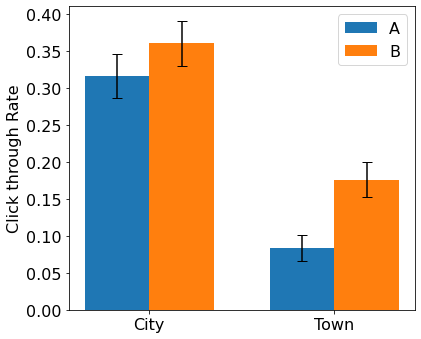

In [21]:
plt.rcParams.update({'font.size': 16})
plt.rcParams["figure.figsize"] = (6,5)
fig, ax = plt.subplots()
x = np.arange(len(p_df1.columns))
width = 0.35
rects1 = ax.bar(x - width/2, height = p_df1.iloc[0], width = width, \
                yerr = p_df1.iloc[1], align='center', \
                ecolor='black', capsize=5, label = 'A')
rects2 = ax.bar(x + width/2, height = p_df2.iloc[0],width = width, 
                yerr = p_df2.iloc[1], align='center', \
                ecolor='black', capsize=5, label = 'B')
ax.set_ylabel('Click through Rate')
ax.set_xticks(x)
ax.set_xticklabels(['City','Town'])
ax.legend()

plt.tight_layout()

In [22]:
model = ols('response ~ treatment + town_size', data = stratified_df).fit()
aov_table = anova_lm(model, typ=1)

In [23]:
print(aov_table)

              df   sum_sq    mean_sq          F        PR(>F)
treatment    1.0    1.156   1.156000   6.890167  8.799737e-03
town_size    1.0   10.816  10.816000  64.467167  2.750424e-15
Residual   997.0  167.272   0.167775        NaN           NaN
